In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 1

## 1. CIFAR10 train, test dataset 가져오기(163MB)
MNIST : 11MB

In [2]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True, 
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5), std = (0.5,0.5,0.5)),
                        ])
                        , target_transform= None, download=False)
cifar_test=dset.CIFAR10("CIFAR10/", train = False, 
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5), std = (0.5,0.5,0.5)),
                        ])
                        , target_transform= None, download=False)

## 2. 대략적인 데이터 형태

('cifar_train len:', 50000)
('cifar_test len:', 10000)
('image data size:', torch.Size([3, 32, 32]))
('label: ', 9)


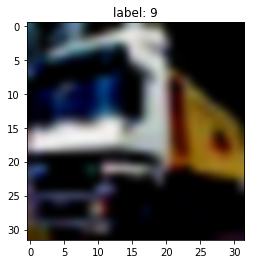

In [3]:
print("cifar_train len:", len(cifar_train))
print("cifar_test len:", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("image data size:", image.size())
print("label: ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation = 'bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs, volatile=True)
        label = Variable(labels)
        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data:{}".format(100*correct/total))


In [5]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers= 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers = 2, drop_last = True)

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,16,3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )

    def forward(self, x):
        out=self.layer(x)
        out=out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

model=CNN()

In [6]:
# === 5. loss, optimizer===
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# === 6. 학습===
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)

        optimizer.zero_grad()
        output=model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if j%1000 ==0:
            print(j, loss)

(0, tensor(2.3070, grad_fn=<NllLossBackward>))
(1000, tensor(2.2936, grad_fn=<NllLossBackward>))
(2000, tensor(2.2653, grad_fn=<NllLossBackward>))
(3000, tensor(1.9261, grad_fn=<NllLossBackward>))


## (4) Data Normalization

In [7]:
ComputeAccr(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data:27.8099994659
